In [20]:
import pandas as pd
import numpy as np
from datetime import datetime
import re
import json
import os
import geocoder 


# https://www.bingmapsportal.com; https://geocoder.readthedocs.io/providers/Bing.html
global BING_MAPS_KEY
BING_MAPS_KEY = os.environ.get('BING_MAPS')

def getLatLon(location):
    try:
        g = geocoder.bing(location, key=BING_MAPS_KEY)
        results = g.json
        return (results['lng'], results['lat'])
    except Exception as e:
        print('Error: {}'.format(e))
        return 'Location Not Found'

def evalCoord(coord):
    return eval(coord)


def toMinutes(t):
    tl = t.split(' ')
    unit = tl[-1]
    try:
        if unit == 'minutes':
            return float(tl[0])
        elif unit == 'seconds':
            return float(tl[0]) / 60
        elif unit == 'hours':
            return float(tl[0]) * 60
    except:
        print(tl)
        return t

def cleanTable(file):
    """
    Clean dataframe of UFO sightings
    """
    # read data
    df = pd.read_csv(
        file, 
        parse_dates=['Date / Time', 'Posted'],
        dtype={
            'Country':str, 
            'State':str, 
            'City':str,
            'Shape':str, 
            'Duration':str,
            'Summary':str,
            'Images':str
            })
    # filter columns; rename
    df = df.rename(columns={'Date / Time': 'Timestamp'})
    # filter to USA (excluding minor outlying islands)
    df = df.loc[df.Country == 'USA'].reset_index(
        drop=True).drop(columns='Country')
    # read json duration data
    with open('../src/data/durations.json') as f:
        durations = json.loads(f.read())
        f.close()
    # map to `Updated_Duration`; impute null with median
    df["Updated_Duration"] = df.Duration.map(durations).replace({'nan': np.nan})
    df.loc[~df.Updated_Duration.isna(), 'Updated_Duration'] = df.loc[~df.Updated_Duration.isna()].Updated_Duration.apply(toMinutes)
    df.loc[df.Updated_Duration.isna(), 'Updated_Duration'] = np.median(df.Updated_Duration.values)
    # get lat lon
    if os.path.exists('data/locations.csv'):
        locations = pd.read_csv('data/locations.csv')
        df['Coords'] = locations.Coords.apply(evalCoord)
        pass
    else:
        df['Coords'] = (df.City + ', ' + df.State).apply(getLatLon)
        df[['City', 'State', 'Coords']].to_csv('data/locations.csv', index=False)
    return df


date_start = '202107'
date_end = '202206'
file = "../src/data/UFOs{}-{}.csv".format(date_start, date_end)
df = cleanTable(file=file)

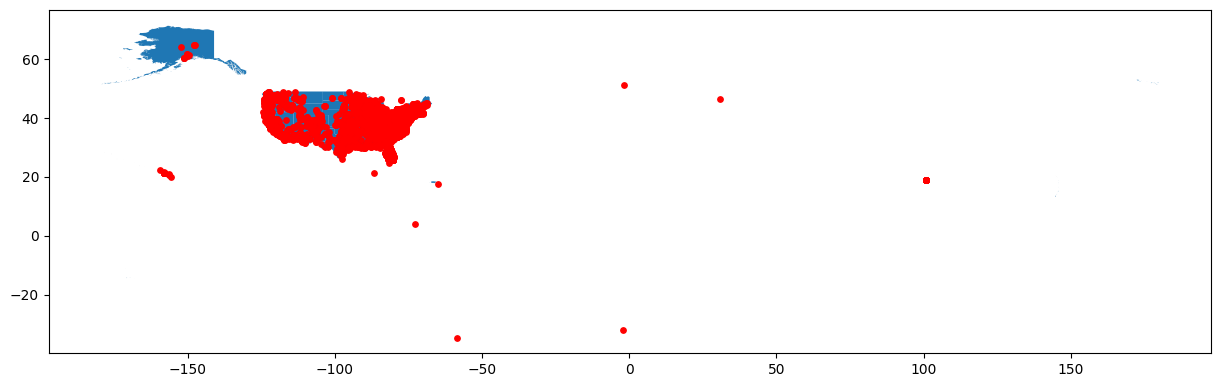

In [22]:
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import matplotlib.pyplot as plt

geometry = [Point(c) for c in df.Coords]#.apply(evalCoord)]
gdf = GeoDataFrame(df, geometry=geometry)
states = geopandas.read_file('../src/data/state.shp')
gdf.plot(ax=states.plot(figsize=(15,15)), marker='o', color='red', markersize=15)
plt.show()